In [16]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.coordinates import Angle
from astropy.stats import sigma_clip
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.wcs import WCS
import matplotlib.cm as cm
import scipy.misc
from astropy.io import fits
from astropy.visualization import ZScaleInterval,LinearStretch,ImageNormalize
get_ipython().magic('matplotlib inline')

In [17]:
def Scaleimgconverter(img):
    norm=ImageNormalize(img,interval=ZScaleInterval(),stretch=LinearStretch())
    return norm

In [18]:
def CountPixel(img, x, y, boundary, lenth = 30):
    x = x.astype(int)
    y = y.astype(int)
    img = img[(y - lenth):(y + lenth), (x - lenth):(x + lenth)]
    return len(np.where(img > boundary)[0])

In [19]:
#### load data to pd.DateFrame

# clipped Bw/NB.fits
names1 = ['NUMBER', 'X_IMAGE', 'Y_IMAGE', 'ALPHA_J2000', 'DELTA_J2000', 'FLUX_APER', 'FLUXERR_APER', \
          'MAG_APER', 'MAGERR_APER', 'FLAGS', 'NITER_MODEL']
Bw_rawdata = pd.DataFrame(np.genfromtxt('BOSS1441_Bw 1.0.cat', delimiter = None, names = names1))
NB_rawdata = pd.DataFrame(np.genfromtxt('BOSS1441_NB 1.2.cat', delimiter = None, names = names1))

names2 = ['_RAJ2000', '_DEJ2000', 'RA_ICRS', 'DE_ICRS', 'mode', 'q_mode', 'class','SDSS12', 'm_SDSS12', 'ObsDate', 'Q', 'umag',\
          'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'zsp', 'zph', 'e_zph', '<zph>']
SDSS_rawdata = pd.DataFrame(np.genfromtxt('SDSS', delimiter = '\t', skip_header = 10,names = names2))

# color transfer from u&r to b band
SDSS_rawdata['bmag'] = SDSS_rawdata.umag - 0.8116 * (SDSS_rawdata.umag - SDSS_rawdata.gmag) + 0.1313
# SDSS_rawdata['bmag'] = SDSS_rawdata.gmag + 0.3130 * (SDSS_rawdata.gmag - SDSS_rawdata.rmag) + 0.2271

In [20]:
#### data screening

# pick points whose flux > 0
Bw_data = Bw_rawdata[Bw_rawdata.FLUX_APER > 0].reset_index(drop = 'True')
NB_data = NB_rawdata[NB_rawdata.FLUX_APER > 0].reset_index(drop = 'True')
Bw_data['mag'] = -2.5 * np.log10(Bw_data.FLUX_APER)
NB_data['mag'] = -2.5 * np.log10(NB_data.FLUX_APER)
# pick points whose class are star(class = 6)
SDSS_data = SDSS_rawdata[(SDSS_rawdata['class'] == 6) & (SDSS_rawdata.bmag > 17.5) & (SDSS_rawdata.bmag < 20.5)].reset_index(drop = 'True')

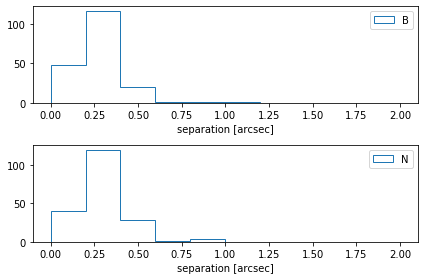

In [21]:
#### match source point between Bw/NB and SDSS

coo_Bw = SkyCoord(list(Bw_data.ALPHA_J2000) * u.degree, list(Bw_data.DELTA_J2000) * u.degree)
coo_NB = SkyCoord(list(NB_data.ALPHA_J2000) * u.degree, list(NB_data.DELTA_J2000) * u.degree)
coo_SDSS = SkyCoord(list(SDSS_data._RAJ2000) * u.degree, list(SDSS_data._DEJ2000) * u.degree)
idx_Bw, d2d_Bw, d3d_Bw = coo_SDSS.match_to_catalog_sky(coo_Bw)
idx_NB, d2d_NB, d3d_NB = coo_SDSS.match_to_catalog_sky(coo_NB)

# separation
plt.subplot(211)
plt.hist(d2d_Bw.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.legend('Bw')
plt.tight_layout()
plt.subplot(212)
plt.hist(d2d_NB.arcsec, histtype='step', range=(0,2))
plt.xlabel('separation [arcsec]')
plt.legend('NB')
plt.tight_layout()
plt.show()

In [22]:
##### select common points in Bw and NB

index_Bw = np.where((d2d_Bw < Angle('0d00m0.5s')))
index_NB = np.where((d2d_NB < Angle('0d00m0.5s')))
index = [index for index in index_Bw[0] if index in index_NB[0]]
idx_Bw = idx_Bw[index]
idx_NB = idx_NB[index]

D:\software\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
D:\software\Anaconda\lib\site-packages\numpy\core\fromnumeric.py:734: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


standard deviation of zero points is: 0.07077188228112063
Zero point for Bw band is:  25.128971586317572
standard deviation of zero points is: 0.2587788917006178
Zero point for NB band is:  22.257978184964387


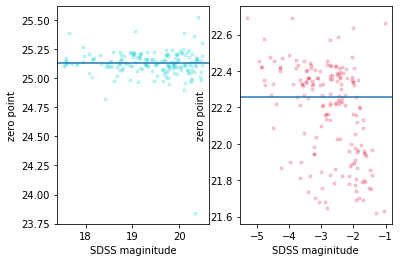

In [23]:
#### calibrate

Bw_mag = np.array([Bw_data['mag'][i] for i in idx_Bw])
NB_mag = np.array([NB_data['mag'][i] for i in idx_NB])
SDSS_mag = [SDSS_data.bmag[i] for i in index]
subt_SB = SDSS_mag - Bw_mag

zp_Bw = sigma_clip(subt_SB, sigma = 3, iters = 5)
zeropoint_Bw = np.median(zp_Bw)
subt_BN = Bw_mag + zeropoint_Bw - NB_mag
zp_NB = sigma_clip(subt_BN, sigma = 3, iters = 5)
zeropoint_NB = np.median(zp_NB)

plt.figure()
plt.subplot(121)
plt.scatter(SDSS_mag, subt_SB, s = np.pi * 1.75**2, c = '#00CED1', alpha=0.2)
plt.axhline(np.median(zp_Bw))
plt.xlabel('SDSS maginitude'); plt.ylabel('zero point')
print('standard deviation of zero points is:', np.std(zp_Bw))
print("Zero point for Bw band is: ", zeropoint_Bw)
plt.subplot(122)
plt.scatter(NB_mag, subt_BN, s = np.pi * 1.75**2, c = '#DC143C', alpha=0.2)
plt.axhline(np.median(zp_NB))
plt.xlabel('SDSS maginitude'); plt.ylabel('zero point')
print('standard deviation of zero points is:', np.std(zp_NB))
print("Zero point for NB band is: ", zeropoint_NB)
plt.show()

In [24]:
#### correct magnitude

Bw_data.mag = Bw_data.mag + zeropoint_Bw
NB_data.mag = NB_data.mag + zeropoint_NB

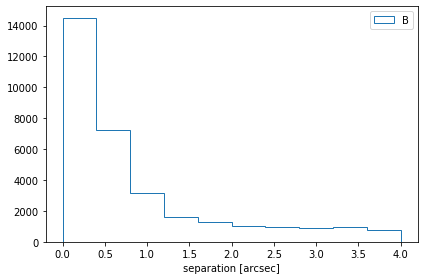

In [25]:
#### match Bw and NB

idx, d2d, d3d = coo_NB.match_to_catalog_sky(coo_Bw)
# seperation
plt.hist(d2d.arcsec, histtype='step', range=(0,4))
plt.xlabel('separation [arcsec]')
plt.legend('Bw_NB')
plt.tight_layout()
plt.show()

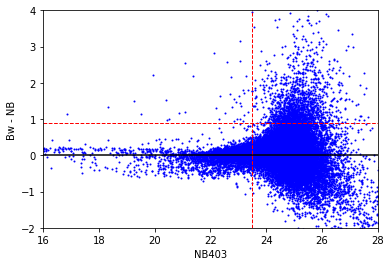

In [26]:
index_Bw_NB = np.where((d2d < Angle('0d00m02s')))
idx = idx[index_Bw_NB]
NB_data = NB_data.loc[index_Bw_NB].reset_index(drop = 'True')
Bw_data = Bw_data.loc[idx].reset_index(drop = 'True')

plt.scatter(NB_data.mag, Bw_data.mag - NB_data.mag, color = 'b', s = 1)
plt.axhline(0, color='k', linestyle='solid')
plt.axhline(0.9, color='r', linestyle='--', linewidth = 1)
plt.axvline(23.5, color='r', linestyle='--', linewidth = 1)
plt.axis([16, 28, -2, 4])
plt.xlabel('NB403')
plt.ylabel('Bw - NB')
plt.show()

In [27]:
Bw_select = Bw_data.copy()
Bw_select['NB_mag'] = NB_data.mag
Bw_select['Bw_minus_NB'] = Bw_data.mag - NB_data.mag
Bw_select['NB_X'] = NB_data.X_IMAGE
Bw_select['NB_Y'] = NB_data.Y_IMAGE
Bw_select['NB_RA'] = NB_data.ALPHA_J2000
Bw_select['NB_DE'] = NB_data.DELTA_J2000
Bw_select =  Bw_select[(Bw_select.Bw_minus_NB > 0.9) & (Bw_select.NB_mag < 23.5)].reset_index(drop = 'True')
# print(Bw_select)
# Bw_select.to_excel('lyablob.xls')

In [28]:
# #### get fits of same size becauce Bw and NB don't overlap totally
# deltaX = round(np.mean(Bw_select.X_IMAGE - Bw_select.NB_X))
# deltaY = round(np.mean(Bw_select.Y_IMAGE - Bw_select.NB_Y))
# Bw_select.X_IMAGE = Bw_select.X_IMAGE - deltaX
# Bw_select.Y_IMAGE = Bw_select.Y_IMAGE - deltaY

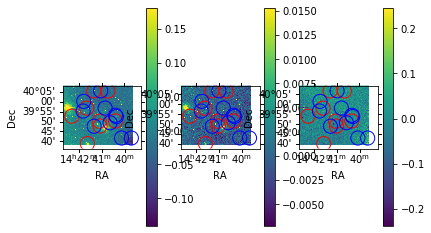

In [29]:
hdu1 = fits.open('BOSS1441_Bw_clip1.fits')[0]
wcs1 = WCS(hdu1.header)#; hdu1.close()
hdu2 = fits.open('BOSS1441_NB_clip.fits')[0]
wcs2 = WCS(hdu2.header)#; hdu2.close()

img = 10**((zeropoint_Bw - zeropoint_NB)/2.5) * hdu2.data - hdu1.data

# get area of degree^2 per pixel
ra, dec = wcs2.all_pix2world([0, 8450], [0, 7150], 1)
deg_to_pix = (dec[1] - dec [0]) * (ra[0] - ra[1])/7150/8450 * 3600**2

# calculate candidate size
degree = np.array([CountPixel(img, Bw_select['NB_X'][i], Bw_select['NB_Y'][i], 0.15, 30) * deg_to_pix for i in range(len(Bw_select['NB_Y']))])
Bw_select['degree']  = degree
Bw_select1 = Bw_select.loc[np.where(degree > 20)]
Bw_select2 = Bw_select.loc[np.where((degree > 10)&(degree < 20))]
# print(Bw_select1); print(Bw_select2)

fig = plt.figure()
ax1 = fig.add_subplot(131, projection=wcs1)
norm1 = Scaleimgconverter(hdu1.data)
plt.imshow(hdu1.data, origin='lower', norm = norm1, cmap=plt.cm.viridis)
plt.colorbar()
# plt.contour(hdu1.data, transform=ax1.get_transform(wcs1), levels=[0.1], colors='white')
plt.scatter(Bw_select1.NB_X, Bw_select1.NB_Y, transform=ax1.get_transform(wcs1), color='', marker='o', edgecolors='r', s=200)
plt.scatter(Bw_select2.NB_X, Bw_select2.NB_Y, transform=ax1.get_transform(wcs1), color='', marker='o', edgecolors='b', s=200)
plt.xlabel('RA'); plt.ylabel('Dec')
ax2 = fig.add_subplot(132, projection=wcs2)
norm2 = Scaleimgconverter(hdu2.data)
plt.imshow(hdu2.data, origin='lower', norm = norm2, cmap=plt.cm.viridis)
plt.colorbar()
# plt.contour(hdu2.data, transform=ax2.get_transform(wcs2), levels=[0.01], colors='white')
plt.scatter(Bw_select1.NB_X, Bw_select1.NB_Y, transform=ax2.get_transform(wcs2), color='', marker='o', edgecolors='r', s=200)
plt.scatter(Bw_select2.NB_X, Bw_select2.NB_Y, transform=ax2.get_transform(wcs2), color='', marker='o', edgecolors='b', s=200)
plt.xlabel('RA'); plt.ylabel('Dec')
ax3 = fig.add_subplot(133, projection=wcs2)
norm = Scaleimgconverter(img)
plt.imshow(img, origin='lower', norm = norm, cmap=plt.cm.viridis)
plt.colorbar()
plt.scatter(Bw_select1.NB_X, Bw_select1.NB_Y, transform=ax3.get_transform(wcs2), color='', marker='o', edgecolors='r', s=200)
plt.scatter(Bw_select2.NB_X, Bw_select2.NB_Y, transform=ax3.get_transform(wcs2), color='', marker='o', edgecolors='b', s=200)
plt.xlabel('RA'); plt.ylabel('Dec')
plt.show()

     NUMBER    X_IMAGE    Y_IMAGE  ALPHA_J2000  DELTA_J2000   FLUX_APER  \
21  23739.0  4672.5327  2543.9731   220.204780    39.902204   56.877440   
43  44442.0  3048.5820  4714.0625   220.351605    40.053101    3.898124   
20  23426.0  3950.4949  2520.7791   220.270145    39.900704   15.098920   
40  41240.0  2618.7043  4361.6191   220.390621    40.028646   62.937240   
55  65162.0  5634.4087  6787.4624   220.116343    40.196682  156.575700   

    FLUXERR_APER  MAG_APER  MAGERR_APER  FLAGS  NITER_MODEL        mag  \
21      7.159419   -4.3874       0.1367    0.0         32.0  20.741621   
43      1.878339   -1.4771       0.5233    2.0        200.0  23.651832   
20      3.690384   -2.9474       0.2654    0.0         39.0  22.181607   
40      7.531037   -4.4973       0.1300    0.0         83.0  20.631702   
55     11.877520   -5.4868       0.0824    2.0         86.0  19.642161   

       NB_mag  Bw_minus_NB       NB_X       NB_Y       NB_RA      NB_DE  \
21  19.253309     1.488313  4

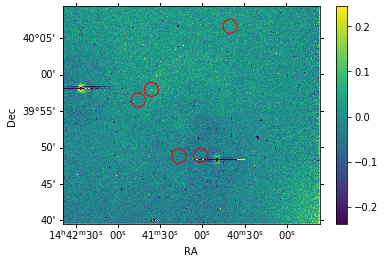

In [30]:
#### select blob

print(Bw_select.loc[[21, 43, 20, 40 , 55]])
fig = plt.figure()
ax = fig.add_subplot(111, projection=wcs2)
plt.imshow(img, origin='lower', norm = norm, cmap=plt.cm.viridis)
plt.colorbar()
plt.scatter(Bw_select.loc[[21, 43, 20, 40 , 55], 'NB_X'], Bw_select.loc[[21, 43, 20, 40 , 55], 'NB_Y'], transform=ax.get_transform(wcs2), color='', marker='o', edgecolors='r', s=200)
plt.xlabel('RA'); plt.ylabel('Dec')
plt.show()